# EE4375: Sixth Lab Session: Galerkin Finite Element Method for the Poisson Equation on the Unit Square 

The **goals** of this sixth lab session of the [EE4375 Course](https://github.com/ziolai/finite_element_electrical_engineering/tree/main) are three-fold. 

The **first** goal is to implement a Galerkin finite element method using linear Lagrange shape functions to solve the two-dimensional Poisson equation $- \bigtriangleup u = f$ on the unit square domain $\Omega=(0,1)^2$ supplied with homogeneous Dirichlet boundary conditions $u = 0$ on $\Gamma = \partial \Omega$. For illustration purposes, the unit square is employed as computational domain. The boundary value problem we intend to solver in this lab session is exactly the same as the boundary value problem we already solved in the third lab session. The extension to non-homogeneous Dirichlet or Neumann boundary conditions is left as an exercise. The assembly and the solve of the linear system will be explored. In the assembly process, a contribution per element to the matrix and right-hand side vector and a loop over elements is employed. The term element here refers to the triangle that is formed by three nodes of the mesh. Similarly to previous lab sessions, a sparse direct solver is employed to solve the resulting linear system. Unlike in the third lab session, non-uniform meshes can be employed. 

The **second** goal is to compare the numerical solution obtained with a two-dimensional analytical reference solution. The same reference solutions as in the third lab session can be used. 

The **third** goal is apply the two-dimensional finite element method to a coil-core-air configuration. Unlike in the third lab session, the mesh can be refined in regions of the computational domain with large variations in the solution.

This lab session complements the lecture slides available at [EE4375 GitHub Directory](https://github.com/ziolai/finite_element_electrical_engineering/tree/main/slides).

<b>Exercises</b> (details still to be supplied)
1. extend testing of assembly and solve stage; 

## Import Packages

In [1]:
try
    using Gmsh: gmsh
catch
    using gmsh
end 

using LinearAlgebra 
using SparseArrays 
using StaticArrays

using Test 
using BenchmarkTools

using Plots 
using GR 

In [2]:
# a point in 2D is a tuple of 2 coordinates 
const Point2D = SVector{2,Float64};

## Section 1: Introduction 

Section 2 introduces data structures and performs 2D mesh generation. Section 3 assembles the stiffness matrix and the load vector. Section 4 solves the linear system. 

## Section 2: Two-Dimensional Mesh Generation

In [3]:
"""
    struct Element 

The struct Element holds information for a single triangular element. 
"""
struct Element
  p1::Point2D                   # coordinates first node 
  p2::Point2D                   # coordinates second node 
  p3::Point2D                   # coordinates third node     
  e1::Int64                     # global index first node
  e2::Int64                     # global index second node
  e3::Int64                     # global index third node
  Emat::MMatrix{3,3,Float64, 9} # matrix of basis function coefficients 
  area::Float64                 # area of the element 
end

"""
    struct Mesh 

The struct Mesh holds information for the entire mesh as an array of triangular elements. 
"""
struct Mesh
  nnodes::Int64               # number of nodes 
  nelems::Int64               # number of elements
  dofPerElem::Int64           # number of dofs per element   
  Elements::Array{Element,1}  # list of Elements 
  bndNodeIds::Vector{Int64}   # indices of nodes where Dirichlet bc are applied  
end

Mesh

In [4]:
# compute the area of the triangle with vertices p1, p2 and p3
"""
    localElement(p1,p2,p3)

Generates area and basis functions for triangular element formed by p1, p2 and p3 
"""
function localElement(p1,p2,p3) 
    p12  = p2 - p1
    p13  = p3 - p1
    area = .5*abs(cross(p12,p13))  
    Xmat = SMatrix{3,3,Float64, 9}(p1[1], p2[1], p3[1], p1[2], p2[2], p3[2], 1, 1, 1) 
    rhs  = SMatrix{3,3,Float64, 9}(1I) 
    Emat = SMatrix{3,3,Float64, 9}(Xmat\rhs);
    return Emat, area
end

localElement

In [5]:
# @code_warntype area_triangle(p1,p2,p3)

In [6]:
# define test data
# see slides for the 5-node mesh  

refElemArea = 0.5
refElemp1   = Point2D(0.,0.); 
refElemp2   = Point2D(1.,0.); 
refElemp3   = Point2D(0.,1.);
refEmat     = SMatrix{3,3}(-1., -1., 1., 1., 0., 0., 0., 1.,0.)
refElem     = Element(refElemp1, refElemp2, refElemp3, 1, 2, 3, refEmat, refElemArea)
refElemIloc = [1, 1, 1, 2, 2, 2, 3, 3, 3]
refElemJloc = [1, 2, 3, 1, 2, 3, 1, 2, 3]  
refElemAloc = refElemArea * [2., -1., -1., -1., 1., 0., -1., 0., 1.]
refElemMloc = refElemArea/3 * [1., 0., 0., 0., 1., 0., 0., 0., 1.]
testA5node  = sparse([1. 0. 0. 0. -1; 0. 1. 0. 0. -1.; 0. 0. 1. 0. -1.; 0. 0. 0. 1. -1.; -1. -1. -1. -1. 4.])
testM5node  = refElemArea/3 * [1. 0. 0. 0. 0.; 0. 1. 0. 0. 0.; 0. 0. 1. 0. 0.; 0. 0. 0. 1. 0.; 0. 0. 0. 0. 2.]
testf5node  = [0., 1/6, 1/3, 1/6, 1/3];

In [7]:
### Section 1.3: Check on Mesh Data Structure

In [8]:
@test localElement(refElemp1,refElemp2,refElemp3) == (refEmat, refElemArea) 

Test Passed

## Section 3: Read Mesh From File and Store Mesh in Struct  

In [9]:
"""
    meshFromGmsh(meshFile)

Reads mesh from files and stores mesh in data structure 
"""
function meshFromGmsh(meshFile)    
    
    #..Initialize GMSH
    gmsh.initialize()
    
    #..Read mesh from file
    gmsh.open(meshFile)

    #..Get the mesh nodes
    #..Observe that although the mesh is two-dimensional,
    #..the z-coordinate that is equal to zero is stored as well.
    #..Observe that the coordinates are stored contiguously for computational efficiency
    node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
    nnodes = length(node_ids)
    #..sort the node coordinates by ID, such that Node one sits at row 1
    tosort = [node_ids node_coord[1:3:end] node_coord[2:3:end]];
    sorted = sortslices(tosort , dims = 1);
    node_ids = sorted[:,1]
    xnode = sorted[:,2]
    ynode = sorted[:,3]

    #..Get the mesh elements
    #..Observe that we get all the two-dimensional triangular elements from the mesh
    element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(2)
    nelems = length(element_ids[1])
      
    #..Construct uninitialized array of length nelements  
    Elements = Array{Element}(undef,nelems)

    #..Construct the array of elements 
    # [e1, e2, e3] = element_connectivity[1][3*(element_id-1)+1:3*(element_id-1)+3]
    for element_id in 1:nelems
        e1 = element_connectivity[1][3*(element_id-1)+1]
        e2 = element_connectivity[1][3*(element_id-1)+2]
        e3 = element_connectivity[1][3*(element_id-1)+3]
        p1 = Point2D(sorted[e1,2], sorted[e1,3])
        p2 = Point2D(sorted[e2,2], sorted[e2,3])
        p3 = Point2D(sorted[e3,2], sorted[e3,3])
        Emat, area = localElement(p1,p2,p3); 
        Elements[element_id] = Element(p1,p2,p3,e1,e2,e3,Emat,area)
    end

    #..retrieve boundary nodes by loop over corner point and boundary edges
    node_ids1=[]; node_ids2=[]; node_ids3=[]; node_ids4=[]; 
    node_ids5=[]; node_ids6=[]; node_ids7=[]; node_ids8=[]; 
    node_ids1, node_coord, _ = gmsh.model.mesh.getNodes(0,1)
    node_ids2, node_coord, _ = gmsh.model.mesh.getNodes(0,2)
    node_ids3, node_coord, _ = gmsh.model.mesh.getNodes(0,3)
    node_ids4, node_coord, _ = gmsh.model.mesh.getNodes(0,4)
    node_ids5, node_coord, _ = gmsh.model.mesh.getNodes(1,1)
    node_ids6, node_coord, _ = gmsh.model.mesh.getNodes(1,2)
    node_ids7, node_coord, _ = gmsh.model.mesh.getNodes(1,3)
    node_ids8, node_coord, _ = gmsh.model.mesh.getNodes(1,4)
    bnd_node_ids = union(node_ids1,node_ids2,node_ids3,node_ids4,node_ids5,node_ids6,node_ids7,node_ids8)
    
    #..Set DOF per element
    dofPerElement = 3 
    
    #..Store data inside mesh struct  
    mesh = Mesh(nnodes,nelems,dofPerElement,Elements,bnd_node_ids) 
    
    #..Finalize gmsh
    gmsh.finalize()
    
    return mesh 
end

#..read nodes from mesh file (useful for post-processing)
function nodesFromGmsh(meshFile)
    
    #..Initialize GMSH
    gmsh.initialize()
    
    #..Read mesh from file
    gmsh.open(meshFile)

    #..Get the mesh nodes
    #..Observe that although the mesh is two-dimensional,
    #..the z-coordinate that is equal to zero is stored as well.
    #..Observe that the coordinates are stored contiguously for computational
    #..efficiency
    node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
    nnodes = length(node_ids)
    #..sort the node coordinates by ID, such that Node one sits at row 1
    tosort = [node_ids node_coord[1:3:end] node_coord[2:3:end]];
    sorted = sortslices(tosort , dims = 1);
    node_ids = sorted[:,1]
    xnode = sorted[:,2]
    ynode = sorted[:,3]

    #..Finalize gmsh
    gmsh.finalize()
    
    return xnode,ynode 
end

nodesFromGmsh (generic function with 1 method)

In [10]:
mesh = meshFromGmsh("data/square-1.msh")
xnode, ynode = nodesFromGmsh("data/square-1.msh");

Info    : Reading 'data/square-1.msh'...
Info    : 9 entities
Info    : 5 nodes
Info    : 12 elements
Info    : Done reading 'data/square-1.msh'
Info    : Reading 'data/square-1.msh'...
Info    : 9 entities
Info    : 5 nodes
Info    : 12 elements
Info    : Done reading 'data/square-1.msh'


In [11]:
totalArea = reduce(+,[mesh.Elements[i].area for i=1:mesh.nelems])
@test totalArea ≈ 1.0

Test Passed

## Section 4: Stiffness Matrix, Mass Matrix and Load Vector Assembly

### Section 1.4: Stiffness Matrix Assembly  

In [12]:
function genLocStiffMat(element::Element)
    v    = SVector(element.e1, element.e2, element.e3)   
    Emat = copy(element.Emat) 
    area = element.area 
    Iloc = SVector{9}(v[i] for j=1:3, i=1:3)
    Jloc = SVector{9}(v[i] for i=1:3, j=1:3) 
    Emat[3,:] .= 0.;  
    Amat = SMatrix{3,3}(area*(transpose(Emat)*Emat))
    Aloc = vec(Amat)
    return Iloc, Jloc, Aloc
end

function genStiffMat(mesh::Mesh)
 
    #..recover number of elements  
    nnodes      = mesh.nnodes 
    nelems      = mesh.nelems 
    dofPerElem  = mesh.dofPerElem
    dofPerElem2 = dofPerElem^2

    #..set range vector 
    irng = SVector{9}(1:9)

    #..preallocate the memory for local matrix contributions 
    Avalues = zeros(Float64,dofPerElem2*nelems)
    I = zeros(Int64,length(Avalues))
    J = zeros(Int64,length(Avalues))

    #..loop over number of elements..
    for element in mesh.Elements 
        Iloc, Jloc, Aloc = genLocStiffMat(element) 
        I[irng] .= Iloc 
        J[irng] .= Jloc 
        Avalues[irng] .= Aloc   
        irng = irng.+dofPerElem2
    end
 
    #..form sparse matrix        
    A = sparse(I,J,Avalues,nnodes,nnodes)
   
    return A; 
end

genStiffMat (generic function with 1 method)

In [13]:
@test genLocStiffMat(refElem) == (refElemIloc, refElemJloc, refElemAloc) 

Test Passed

In [14]:
mesh = meshFromGmsh("data/square-1.msh");
A = genStiffMat(mesh)
@test A == testA5node

Info    : Reading 'data/square-1.msh'...
Info    : 9 entities
Info    : 5 nodes
Info    : 12 elements
Info    : Done reading 'data/square-1.msh'


Test Passed

In [15]:
mesh = meshFromGmsh("data/square-1.msh");   @time genStiffMat(mesh); # <= force recompilation 
mesh = meshFromGmsh("data/square-1.msh");   @time genStiffMat(mesh); 
mesh = meshFromGmsh("data/square-10.msh");  @time genStiffMat(mesh); 
mesh = meshFromGmsh("data/square-100.msh"); @time genStiffMat(mesh); 

Info    : Reading 'data/square-1.msh'...
Info    : 9 entities
Info    : 5 nodes
Info    : 12 elements
Info    : Done reading 'data/square-1.msh'
  0.000011 seconds (13 allocations: 2.625 KiB)
Info    : Reading 'data/square-1.msh'...
Info    : 9 entities
Info    : 5 nodes
Info    : 12 elements
Info    : Done reading 'data/square-1.msh'
  0.000009 seconds (13 allocations: 2.625 KiB)
Info    : Reading 'data/square-10.msh'...
Info    : 9 entities
Info    : 142 nodes
Info    : 286 elements
Info    : Done reading 'data/square-10.msh'
  0.000020 seconds (18 allocations: 104.188 KiB)
Info    : Reading 'data/square-100.msh'...
Info    : 9 entities
Info    : 11833 nodes
Info    : 23668 elements
Info    : Done reading 'data/square-100.msh'
  0.002255 seconds (23 allocations: 9.511 MiB)


### Section 2.4: Mass Matrix Assembly

In [16]:
function genLocMassMat(element::Element)
    v    = SVector(element.e1, element.e2, element.e3)  
    Emat = copy(element.Emat)
    area = element.area 
    Iloc = SVector{9}(v[i] for j=1:3, i=1:3)
    Jloc = SVector{9}(v[i] for i=1:3, j=1:3) 
    Mmat = area/3*SMatrix{3,3}(1I) 
    Mloc = vec(Mmat)
    return Iloc, Jloc, Mloc
end

function genMassMat(mesh::Mesh)
 
    #..recover number of elements  
    nnodes      = mesh.nnodes 
    nelems      = mesh.nelems 
    dofPerElem  = mesh.dofPerElem
    dofPerElem2 = dofPerElem^2

    #..set range vector 
    irng = SVector{9}(1:9)

    #..preallocate the memory for local matrix contributions 
    Mvalues = zeros(Float64,dofPerElem2*nelems)
    I = zeros(Int64,length(Mvalues))
    J = zeros(Int64,length(Mvalues)) 
    
    #..loop over number of elements..
    for element in mesh.Elements 
        Iloc, Jloc, Mloc = genLocMassMat(element) 
        I[irng] .= Iloc 
        J[irng] .= Jloc 
        Mvalues[irng] .= Mloc   
        irng = irng.+dofPerElem2
    end

    #..form sparse matrix
    M = sparse(I,J,Mvalues)
   
    return M; 
end

genMassMat (generic function with 1 method)

In [17]:
Iloc, Jloc, Mloc = genLocMassMat(refElem)
@test genLocMassMat(refElem) == (refElemIloc, refElemJloc, refElemMloc)

Test Passed

In [18]:
mesh = meshFromGmsh("data/square-1.msh");
M = genMassMat(mesh)
@test M == testM5node 

Info    : Reading 'data/square-1.msh'...
Info    : 9 entities
Info    : 5 nodes
Info    : 12 elements
Info    : Done reading 'data/square-1.msh'


Test Passed

### Section 4.3: Right-Hand Side Assembly using Analytically Specified Source Function 

In [19]:
mySourceFct(x) = x[1]+x[2] 

function genLocVector(element::Element, sourceFct::Function)
    ploc = SVector(element.p1, element.p2, element.p3)   
    Iloc = SVector(element.e1, element.e2, element.e3)   
    area = element.area 
    floc = area/3*sourceFct.(ploc)
    return Iloc, floc
end

function genVector(mesh, sourceFct::F) where F 
 
    #..recover number of nodes  
    nnodes = mesh.nnodes 
     
    #..preallocate the memory for local matrix contributions 
    f = zeros(Float64,nnodes)

    #..loop over number of elements..
    for element in mesh.Elements
        Iloc, floc = genLocVector(element,sourceFct)
        f[Iloc] += floc 
    end
       
    return f; 
end

genVector (generic function with 1 method)

In [20]:
mesh = meshFromGmsh("data/square-1.msh");  
f = genVector(mesh,mySourceFct)
@test f ≈ testf5node 

Info    : Reading 'data/square-1.msh'...
Info    : 9 entities
Info    : 5 nodes
Info    : 12 elements
Info    : Done reading 'data/square-1.msh'


Test Passed

In [21]:
mesh = meshFromGmsh("data/square-1.msh");   @time genVector(mesh,mySourceFct); # <= force recompilation
mesh = meshFromGmsh("data/square-1.msh");   @time genVector(mesh,mySourceFct); 
mesh = meshFromGmsh("data/square-10.msh");  @time genVector(mesh,mySourceFct); 
mesh = meshFromGmsh("data/square-100.msh"); @time genVector(mesh,mySourceFct); 

Info    : Reading 'data/square-1.msh'...
Info    : 9 entities
Info    : 5 nodes
Info    : 12 elements
Info    : Done reading 'data/square-1.msh'
  0.000010 seconds (1 allocation: 96 bytes)
Info    : Reading 'data/square-1.msh'...
Info    : 9 entities
Info    : 5 nodes
Info    : 12 elements
Info    : Done reading 'data/square-1.msh'
  0.000005 seconds (1 allocation: 96 bytes)
Info    : Reading 'data/square-10.msh'...
Info    : 9 entities
Info    : 142 nodes
Info    : 286 elements
Info    : Done reading 'data/square-10.msh'
  0.000007 seconds (1 allocation: 1.219 KiB)
Info    : Reading 'data/square-100.msh'...
Info    : 9 entities
Info    : 11833 nodes
Info    : 23668 elements
Info    : Done reading 'data/square-100.msh'
  0.000079 seconds (2 allocations: 92.547 KiB)


## Section 4: FEM Solve  

### Section 1.4: Handle Dirichlet Essential Boundary Conditions 

In [22]:
function handleBoundary!(mesh,A,f)
    bndNodeIds = mesh.bndNodeIds; 
    #..handle essential boundary conditions 
    A[bndNodeIds,:] .= 0;
    A[bndNodeIds,bndNodeIds] = Diagonal(ones(size(bndNodeIds)))
    f[bndNodeIds] .= 0;
    return A, f  
end

handleBoundary! (generic function with 1 method)

In [23]:
mesh = meshFromGmsh("data/square-10.msh"); A = genStiffMat(mesh); f = genVector(mesh,mySourceFct);
A,f = handleBoundary!(mesh,A,f);

Info    : Reading 'data/square-10.msh'...
Info    : 9 entities
Info    : 142 nodes
Info    : 286 elements
Info    : Done reading 'data/square-10.msh'


### Section 2.4: Solve Linear System 

In [24]:
function genSolution!(mesh,A,f)
    A, f = handleBoundary!(mesh,A,f)
    u = A\f 
    return u 
end

genSolution! (generic function with 1 method)

In [25]:
mesh = meshFromGmsh("data/square-10.msh");   
A = genStiffMat(mesh); f= genVector(mesh,mySourceFct); # <= force recompilation
@time genSolution!(mesh,A,f);

Info    : Reading 'data/square-10.msh'...
Info    : 9 entities
Info    : 142 nodes
Info    : 286 elements
Info    : Done reading 'data/square-10.msh'
  0.576948 seconds (2.26 M allocations: 154.160 MiB, 5.58% gc time, 99.94% compilation time)


Info    : Reading 'data/square-10.msh'...
Info    : 9 entities
Info    : 142 nodes
Info    : 286 elements
Info    : Done reading 'data/square-10.msh'
Info    : Reading 'data/square-10.msh'...
Info    : 9 entities
Info    : 142 nodes
Info    : 286 elements
Info    : Done reading 'data/square-10.msh'
  0.000021 seconds (19 allocations: 104.234 KiB)
  0.000216 seconds (90 allocations: 299.297 KiB)


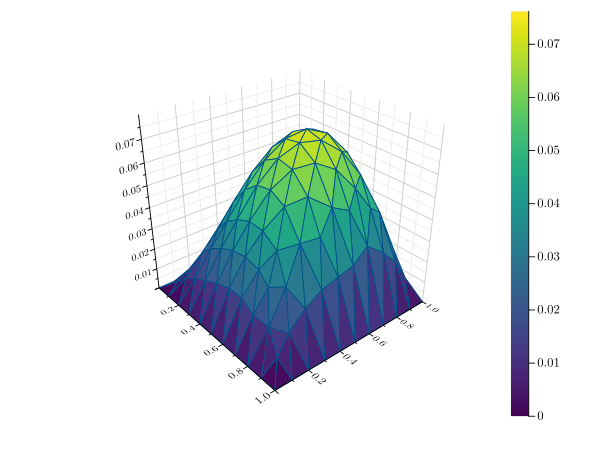

In [26]:
mesh = meshFromGmsh("data/square-10.msh");  
xnode,ynode = nodesFromGmsh("data/square-10.msh")
@time A = genStiffMat(mesh); f= genVector(mesh,mySourceFct); 
@time u = genSolution!(mesh,A,f)
GR.trisurf(xnode,ynode,u)

In [27]:
mesh = meshFromGmsh("data/square-1.msh");   
@time A = genStiffMat(mesh); f= genVector(mesh,mySourceFct); 
@time u = genSolution!(mesh,A,f)

mesh = meshFromGmsh("data/square-1.msh");   
@time A = genStiffMat(mesh); f= genVector(mesh,mySourceFct); 
@time u = genSolution!(mesh,A,f)

mesh = meshFromGmsh("data/square-10.msh");  
@time A = genStiffMat(mesh); f= genVector(mesh,mySourceFct); 
@time u = genSolution!(mesh,A,f)

mesh = meshFromGmsh("data/square-100.msh"); 
@time A = genStiffMat(mesh); f= genVector(mesh,mySourceFct); 
@time u = genSolution!(mesh,A,f)

#mesh = meshFromGmsh("data/square-1000.msh"); 
#@time A = genStiffMat(mesh); f= genVector(mesh,mySourceFct); 
#@time u = genSolution!(mesh,A,f);

Info    : Reading 'data/square-1.msh'...
Info    : 9 entities
Info    : 5 nodes
Info    : 12 elements
Info    : Done reading 'data/square-1.msh'
  0.000004 seconds (14 allocations: 2.672 KiB)
  0.000013 seconds (12 allocations: 2.547 KiB)
Info    : Reading 'data/square-1.msh'...
Info    : 9 entities
Info    : 5 nodes
Info    : 12 elements
Info    : Done reading 'data/square-1.msh'
  0.000009 seconds (14 allocations: 2.672 KiB)
  0.000008 seconds (12 allocations: 2.547 KiB)
Info    : Reading 'data/square-10.msh'...
Info    : 9 entities
Info    : 142 nodes
Info    : 286 elements
Info    : Done reading 'data/square-10.msh'
  0.000025 seconds (19 allocations: 104.234 KiB)
  0.000226 seconds (90 allocations: 299.297 KiB)
Info    : Reading 'data/square-100.msh'...
Info    : 9 entities
Info    : 11833 nodes
Info    : 23668 elements
Info    : Done reading 'data/square-100.msh'
  0.002296 seconds (24 allocations: 9.511 MiB)
  0.029165 seconds (105 allocations: 26.782 MiB, 15.17% gc time)


11833-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.007120309932556252
 0.0017552024241115766
 0.0015167506143699944
 0.0030225130974867137
 0.004539798950780197
 0.005252718817420788
 0.005138297191754396
 0.000891926621177276
 0.005525588549861283
 0.0029103977295329214
 0.0026169990600696832
 0.008181992390845523

## Section 3: Magnetic Field by Coil  

In [28]:
# source function attached to the callable struct 
function mySourceFct(x)
    return (x[1]>0.3)*(x[1]<0.7)*(x[2]>0.7)*(x[2]<0.9) - (x[1]>0.3)*(x[1]<0.7)*(x[2]>0.1)*(x[2]<0.3)
#    return (x[1].>0.3)
end

mySourceFct (generic function with 1 method)

Info    : Reading 'data/square-10.msh'...
Info    : 9 entities
Info    : 142 nodes
Info    : 286 elements
Info    : Done reading 'data/square-10.msh'
Info    : Reading 'data/square-10.msh'...
Info    : 9 entities
Info    : 142 nodes
Info    : 286 elements
Info    : Done reading 'data/square-10.msh'


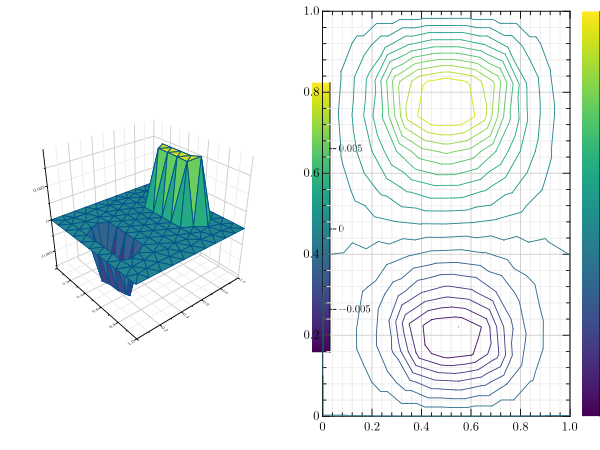

In [29]:
mesh = meshFromGmsh("data/square-10.msh"); 
xnode, ynode = nodesFromGmsh("data/square-10.msh")
A = genStiffMat(mesh); f= genVector(mesh,mySourceFct); 
u = genSolution!(mesh,A,f);

GR.subplot(1,2,1)
p1 = GR.trisurf(xnode,ynode,f)
GR.subplot(1,2,2)
p1 = GR.tricont(xnode,ynode,u)

## Section 4: Post-Processing for the Magnetic Flux 

In [30]:
function genDerivLoc(element::Element,u)
    ploc = SVector(element.p1, element.p2, element.p3)   
    Iloc = SVector(element.e1, element.e2, element.e3)   
    Emat = copy(element.Emat)
    Emat[3,:] .= 0.; 
    area = element.area 
    uloc = u[Iloc] 
    xmid = sum(ploc)/3
    Bx = -dot(uloc,Emat[2,:])
    By = dot(uloc,Emat[1,:])
    normB2 = Bx^2 + By^2 
    return xmid, Bx, By, normB2
end

function genDeriv(mesh, u)

    #..recover number of elements  
    nelems = mesh.nelems 
    nnodes = mesh.nnodes 

    #..allocate memory for arrays 
    xmid   = zeros(Point2D,nelems)
    Bx     = zeros(Float64,nelems)
    By     = zeros(Float64,nelems)
    normB2 = zeros(Float64,nelems)

    for element_id in 1:nelems
        element::Element = mesh.Elements[element_id]
        xmid[element_id], Bx[element_id], By[element_id], normB2[element_id] = genDerivLoc(element,u) 
    end 
    
    return xmid, Bx, By, normB2 
end

genDeriv (generic function with 1 method)

In [31]:
xmid, Bx, By, normB2 = genDeriv(mesh, u); 
xxmid = [x[1] for x in xmid]
yxmid = [x[2] for x in xmid]
display(typeof(xxmid)) 
display(typeof(yxmid))
display(typeof(Bx))

Vector{Float64} (alias for Array{Float64, 1})

Vector{Float64} (alias for Array{Float64, 1})

Vector{Float64} (alias for Array{Float64, 1})

In [32]:
x, y = nodesFromGmsh("data/square-1.msh")
z = zeros(size(x))
II = [mesh.Elements[i].e1 for i=1:mesh.nelems]
JJ = [mesh.Elements[i].e2 for i=1:mesh.nelems]
KK = [mesh.Elements[i].e3 for i=1:mesh.nelems]
value = [mesh.Elements[i].p1[1] for i=1:mesh.nelems];

Info    : Reading 'data/square-1.msh'...
Info    : 9 entities
Info    : 5 nodes
Info    : 12 elements
Info    : Done reading 'data/square-1.msh'


In [33]:
x

5-element Vector{Float64}:
 0.0
 1.0
 1.0
 0.0
 0.5

In [34]:
using PlotlyJS

LoadError: ArgumentError: Package PlotlyJS not found in current path.
- Run `import Pkg; Pkg.add("PlotlyJS")` to install the PlotlyJS package.

In [35]:
methods(PlotlyJS.mesh3d) 

LoadError: UndefVarError: `PlotlyJS` not defined

In [ ]:
edit("/Users/djplahaye/.julia/packages/PlotlyBase/4NWbR/src/api.jl")

In [ ]:
x = [0., 1, 2, 0]
y = [0., 0, 1, 2]
z = [0., 2, 0, 1]
i = [0, 0, 0, 1]
j = [1, 2, 3, 2]
k = [2, 3, 1, 3]
PlotlyJS.mesh3d(x, y, z) 

In [ ]:
PlotlyJS.mesh3d(x,y,z)

In [ ]:
#Plots.plot(xmid) # works 
#Plots.surface(xxmid, yxmid,Bx) # works 
#Plots.surface(xxmid, yxmid,(x, y) -> x^2 + y^2) # works
#Plots.contour(xxmid[p], yxmid[p],(x, y) -> x^2 + y^2)

In [ ]:
# GR.surface(xxmid, yxmid,(x, y) -> x^2 + y^2)\
GR.scatter(xxmid, yxmid,(x, y) -> x^2 + y^2)

invalid number of points
invalid number of points
invalid number of points
GKS: Viewport is not within the NDC unit square in routine SET_VIEWPORT


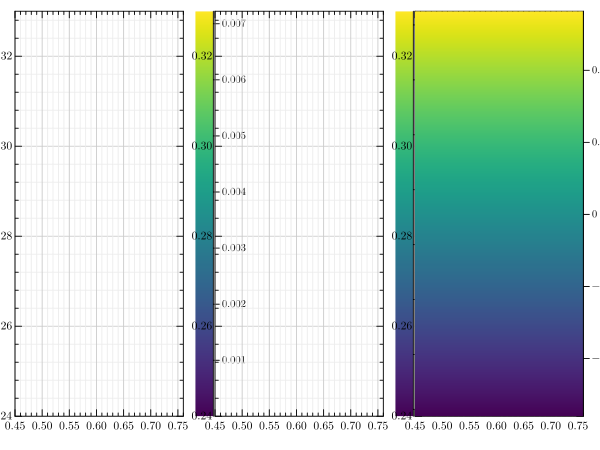

In [33]:
xmid, Bx, By, normB2 = genDeriv(mesh, u)
GR.subplot(1,3,1)
p1 = GR.tricont(xmid[1],xmid[2],normB2)
GR.subplot(1,3,2)
p1 = GR.tricont(xmid[1],xmid[2],Bx)
GR.subplot(1,3,3)
p1 = GR.tricont(xmid[1],xmid[2],By)

## Write solution to file using GMSH 

In [ ]:
try
    using Gmsh: gmsh
catch
    using gmsh
end
     
using WriteVTK
 
gmsh.initialize()

gmsh.open(data)

node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
nnodes = length(node_ids)
tosort = [node_ids node_coord[1:3:end] node_coord[2:3:end]];
sorted = sortslices(tosort , dims = 1);
node_ids = sorted[:,1]
xnode = sorted[:,2]
ynode = sorted[:,3]

element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(2)
nelements = length(element_ids[1])

#..initialize elements 
elements = [zeros(Int, 3) for i in 1:nelements];
#..loop over elements and store data into elements     
for element_id in 1:nelements
    node1_id = element_connectivity[1][3*(element_id-1)+1]
    node2_id = element_connectivity[1][3*(element_id-1)+2]
    node3_id = element_connectivity[1][3*(element_id-1)+3]
        
    # Store connectivity in a convenient format
    elements[element_id] = [node1_id, node2_id, node3_id]
end

#..5/7: Define nodes (points) and elements (cells)s
#..The MeshCell data structure in provided by the WriteVTK.jl package   
points = [xnode ynode]';
cells = [MeshCell(VTKCellTypes.VTK_TRIANGLE, el) for el in elements];

#..6/7: Create VTK file structure using nodes and elements

vtk_grid("mesh", points, cells) do vtk
    vtk["Deflection",VTKPointData()] = u
    vtk_save(vtk)
end

#..7/7: Finalize gmsh engine 
gmsh.finalize() 